In [1]:
import numpy as np
import copy
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import utils
from utils.get_nn_models import *
from utils.sbiutils import *
from utils.torchutils import *
from inference.base import *
import torch
import pickle
import seaborn as sns
from inference.snpe.snpe_c import SNPE_C as SNPE
import io
from utils.corruption import *
# from networks.summary_nets import LotkaSummary

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
def load_models(root_name: str, device: torch.device):
    sum_net = torch.load("{root_name}/sum_net.pkl".format(root_name=root_name), map_location=device)

    density_estimator = torch.load("{root_name}/density_estimator.pkl".format(root_name=root_name), map_location=device)

    with open("{root_name}/posterior.pkl".format(root_name=root_name), "rb") as handle:
        posterior = CPU_Unpickler(handle).load() if device == torch.device('cpu') else pickle.load(handle)
    
#     with open("{root_name}/inference.pkl".format(root_name=root_name), "rb") as handle:
#         inference = CPU_Unpickler(handle).load() if device == torch.device('cpu') else pickle.load(handle)
    
    return sum_net, density_estimator, posterior

In [3]:
def oup(theta, n=50, N=100):
    if len(theta.shape) == 1:
        theta1 = theta[0]
        theta2 = torch.exp(theta[1])
    else:
        theta1 = theta[0, 0]
        theta2 = torch.exp(theta[0, 1])

    # noises
    T, d = 10.0, n+1
    dt = T/d
    Y = torch.zeros([N, n])
    Y[:, 0] = 10
    for i in range(N):
        w = torch.normal(0., 1., size=(n,1))

        for t in range(n-1):
            mu, sigma = theta1*(theta2 - Y[i, t])*dt, 0.5*(dt**0.5)*w[t]
            Y[i, t+1] = Y[i, t] + mu + sigma
    return Y

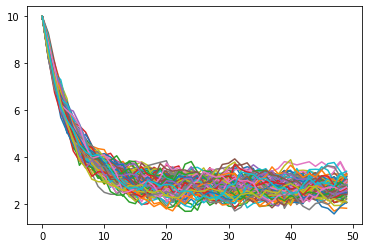

In [4]:
theta = torch.tensor([1, 1])
Y = oup(theta)
for i in range(100):
    plt.plot(range(50), Y[i])

In [5]:
prior = [Uniform(torch.zeros(1), torch.ones(1)),
         Uniform(-2*torch.zeros(1), 2*torch.ones(1))]
simulator, prior = prepare_for_sbi(oup, prior)

num_simulations = 4000

/Users/huangd5/Library/CloudStorage/OneDrive-AaltoUniversity/Projects/Robust SBI/Robust-SBI/utils/user_input_checks.py:64: UserWarning: Prior was provided as a sequence of 2 priors. They will be
            interpreted as independent of each other and matched in order to the
            components of the parameter.
  warnings.warn(


In [99]:
theta, x = simulate_for_sbi(oup, prior, num_simulations=num_simulations)
x = x.reshape(num_simulations, 100, 50).to(device)
theta = theta.to(device)
np.save("data/oup_x_4000.npy", x)
np.save("data/oup_theta_4000.npy", theta)

Running 4000 simulations.:   0%|          | 0/4000 [00:00<?, ?it/s]

In [6]:
x = torch.tensor(np.load("data/oup_x_4000.npy")).to(device)
theta = torch.tensor(np.load("data/oup_theta_4000.npy")).to(device)
print("x shape", x.shape)
print("theta shape", theta.shape)

x shape torch.Size([4000, 100, 50])
theta shape torch.Size([4000, 2])


In [7]:
class OUPSummary(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(OUPSummary, self).__init__()

        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.num_layers = 1
        self.lstm = nn.LSTM(1, self.hidden_dim, self.num_layers, batch_first=True)

        self.conv = nn.Sequential(nn.Conv1d(self.input_size, self.hidden_dim, 3, 2),
                                  nn.Conv1d(self.hidden_dim, self.hidden_dim, 3, 2),
                                  nn.Conv1d(4, self.hidden_dim, 3, 3),
                                  nn.AvgPool1d(3))
        self.fc = nn.Linear(self.hidden_dim, 4)

    def forward(self, Y):
        current_device = Y.device
        batch_size = Y.size(0)

#         embeddings_conv = self.conv(Y.reshape(-1, 1, 40)).reshape(-1, 100, 4)
#         stat_conv = torch.mean(embeddings_conv, dim=1)

        hidden, c = self.init_hidden(100*batch_size, current_device)
        out, (embeddings_lstm, c) = self.lstm(Y.reshape(100*batch_size, 50, 1), (hidden, c))

        embeddings_lstm = embeddings_lstm.reshape(batch_size, 100, self.hidden_dim)

        stat_lstm = torch.mean(embeddings_lstm, dim=1)
        out = self.fc(stat_lstm)

#         stat = torch.cat([stat_conv, stat_lstm], dim=1)
        
        return embeddings_lstm, out

    def init_hidden(self, batch_size, current_device):
        hidden = torch.zeros(1*self.num_layers, batch_size, self.hidden_dim).to(current_device)
        c = torch.zeros(1*self.num_layers, batch_size, self.hidden_dim).to(current_device)
        return hidden, c

In [9]:
sum_net_normal = OUPSummary(input_size=1, hidden_dim=64).to(device)

neural_posterior_normal = posterior_nn(
    model="maf", 
    embedding_net=sum_net_normal, 
    hidden_features=20, 
    num_transforms=3)

inference_normal = SNPE(prior=prior, density_estimator=neural_posterior_normal, device="cpu")
density_estimator_normal = inference_normal.append_simulations(theta, x.unsqueeze(1)).train(corrupt_data_training="none")
posterior_normal = inference_normal.build_posterior(density_estimator_normal)

 Neural network successfully converged after 92 epochs.

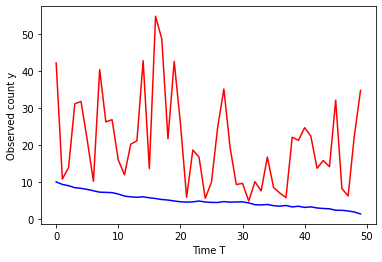

In [37]:
theta_gt = torch.tensor([0.5, 1])

obs = oup(theta_gt).to(device)
obs_cont = magnitude_sigma(obs, var=20, length=50)

plt.plot(range(50), obs[2], color="blue")
plt.plot(range(50), obs_cont[2], color="red")
plt.xlabel("Time T")
plt.ylabel("Observed count y")
plt.show()

In [51]:
root_name = "objects/oup/var=20_mmd_beta=2.0_theta=[0.5, 1.0]_num=4000/0"
sum_net_robust, density_estimator_robust, posterior_robust = load_models(root_name, device)

root_name = "objects/oup/var=20_none_beta=1.0_theta=[0.5, 1.0]/3"
sum_net_normal, density_estimator_normal, posterior_normal = load_models(root_name, device)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

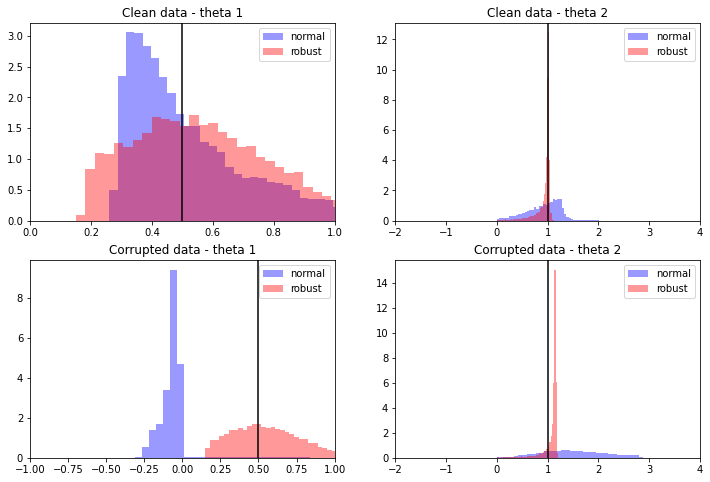

In [52]:
post_samples_normal_clean = posterior_normal.sample((10000,), x=obs.reshape(1, 1, 100, 50))
post_samples_robust_clean = posterior_robust.sample((10000,), x=obs.reshape(1, 1, 100, 50))
post_samples_normal_cont = posterior_normal.sample((10000,), x=obs_cont.reshape(1, 1, 100, 50))
post_samples_robust_cont = posterior_robust.sample((10000,), x=obs_cont.reshape(1, 1, 100, 50))

plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.axvline(x=theta_gt[0],ls="-",c="black")
sns.distplot(post_samples_normal_clean[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_clean[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
plt.legend()
plt.xlim(0, 1)
plt.title("Clean data - theta 1")

plt.subplot(2, 2, 2)
plt.axvline(x=theta_gt[1],ls="-",c="black")
sns.distplot(post_samples_normal_clean[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_clean[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
plt.legend()
plt.xlim(-2, 4)
plt.title("Clean data - theta 2")

plt.subplot(2, 2, 3)
plt.axvline(x=theta_gt[0],ls="-",c="black")
sns.distplot(post_samples_normal_cont[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_cont[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
plt.legend()
plt.xlim(-1, 1)
plt.title("Corrupted data - theta 1")

plt.subplot(2, 2, 4)
plt.axvline(x=theta_gt[1],ls="-",c="black")
sns.distplot(post_samples_normal_cont[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="normal")
sns.distplot(post_samples_robust_cont[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="robust")
plt.legend()
plt.xlim(-2, 4)
plt.title("Corrupted data - theta 2")
plt.show()


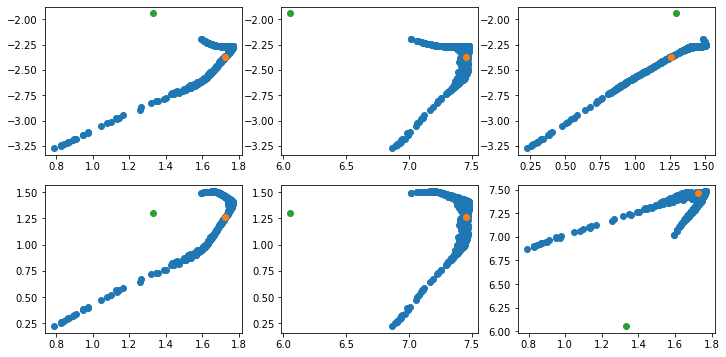

In [53]:
sum_net_normal_0 = copy.deepcopy(sum_net_normal)

obs_summary = sum_net_normal_0(obs.unsqueeze(0))[1].detach().numpy()
obs_cont_summary = sum_net_normal_0(obs_cont.unsqueeze(0))[1].detach().numpy()

x_summary = sum_net_normal_0(x[:500])[1].detach().numpy()

plt.figure(figsize=(12,6))
plt.subplot(2, 3, 1)
plt.scatter(x_summary[:, 0], x_summary[:, 3])
plt.scatter(obs_summary[0, 0], obs_summary[0, 3])
plt.scatter(obs_cont_summary[0, 0], obs_cont_summary[0, 3])

plt.subplot(2, 3, 2)
plt.scatter(x_summary[:, 1], x_summary[:, 3])
plt.scatter(obs_summary[0, 1], obs_summary[0, 3])
plt.scatter(obs_cont_summary[0, 1], obs_cont_summary[0, 3])

plt.subplot(2, 3, 3)
plt.scatter(x_summary[:, 2], x_summary[:, 3])
plt.scatter(obs_summary[0, 2], obs_summary[0, 3])
plt.scatter(obs_cont_summary[0, 2], obs_cont_summary[0, 3])

plt.subplot(2, 3, 4)
plt.scatter(x_summary[:, 0], x_summary[:, 2])
plt.scatter(obs_summary[0, 0], obs_summary[0, 2])
plt.scatter(obs_cont_summary[0, 0], obs_cont_summary[0, 2])

plt.subplot(2, 3, 5)
plt.scatter(x_summary[:, 1], x_summary[:, 2])
plt.scatter(obs_summary[0, 1], obs_summary[0, 2])
plt.scatter(obs_cont_summary[0, 1], obs_cont_summary[0, 2])

plt.subplot(2, 3, 6)
plt.scatter(x_summary[:, 0], x_summary[:, 1])
plt.scatter(obs_summary[0, 0], obs_summary[0, 1])
plt.scatter(obs_cont_summary[0, 0], obs_cont_summary[0, 1])
plt.show()

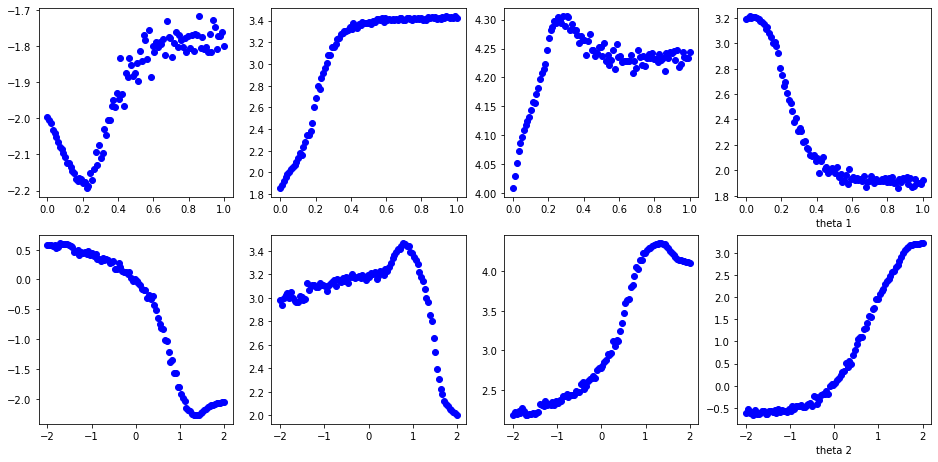

In [16]:
n_samples = 100

theta_1 = np.linspace(0, 1, 100)
theta_2= np.linspace(-2, 2, 100)

theta_1_unchange = np.repeat(0.5, 100)
theta_2_unchange = np.repeat(1., 100)


thetas_1 = torch.tensor(np.stack((theta_1, theta_2_unchange), axis=-1))
thetas_2 = torch.tensor(np.stack((theta_1_unchange, theta_2), axis=-1))


hidden_1_normal = np.zeros((len(thetas_1), 4))
hidden_2_normal = np.zeros((len(thetas_2), 4))
# hidden_1_robust = np.zeros((len(thetas_1), 4))
# hidden_2_robust = np.zeros((len(thetas_2), 4))

for i in range(len(thetas_1)):
    obs_1 = oup(thetas_1[i].reshape(-1, 2)).reshape(1, n_samples, 50).to(device)
    obs_2 = oup(thetas_2[i].reshape(-1, 2)).reshape(1, n_samples, 50).to(device)

    hidden_1_normal[i] = sum_net_normal(obs_1)[1].reshape(-1).cpu().detach().numpy()
    hidden_2_normal[i] = sum_net_normal(obs_2)[1].reshape(-1).cpu().detach().numpy()

#     hidden_1_robust[i] = sum_net_robust(obs_1)[1].reshape(-1).cpu().detach().numpy()
#     hidden_2_robust[i] = sum_net_robust(obs_2)[1].reshape(-1).cpu().detach().numpy()
    

plt.figure(figsize=(16,16))
plt.subplot(4, 4, 1)
plt.scatter(theta_1, hidden_1_normal[:, 0], color="blue")
# plt.scatter(theta_1, hidden_1_robust[:, 0], color="red")
plt.subplot(4, 4, 2)
plt.scatter(theta_1, hidden_1_normal[:, 1], color="blue")
# plt.scatter(theta_1, hidden_1_robust[:, 1], color="red")
plt.subplot(4, 4, 3)
plt.scatter(theta_1, hidden_1_normal[:, 2], color="blue")
# plt.scatter(theta_1, hidden_1_robust[:, 2], color="red")
plt.subplot(4, 4, 4)
plt.scatter(theta_1, hidden_1_normal[:, 3], color="blue")
# plt.scatter(theta_1, hidden_1_robust[:, 3], color="red")
plt.xlabel("theta 1")

plt.subplot(4, 4, 5)
plt.scatter(theta_2, hidden_2_normal[:, 0], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 0], color="red")
plt.subplot(4, 4, 6)
plt.scatter(theta_2, hidden_2_normal[:, 1], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 1], color="red")
plt.subplot(4, 4, 7)
plt.scatter(theta_2, hidden_2_normal[:, 2], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 2], color="red")
plt.subplot(4, 4, 8)
plt.scatter(theta_2, hidden_2_normal[:, 3], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 3], color="red")
plt.xlabel("theta 2")


plt.show()